# Build a tile index csv and Mosaic Json for COGs

##### Path to your icesat2_boreal/lib dir - clone the icesat2_boreal GitHub repository
https://github.com/lauraduncanson/icesat2_boreal.git

In [4]:
ICESAT2_BOREAL_REPO_PATH = '/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'

In [5]:
!pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt
#!pip install -U pygeos

  Using cached pygeos-0.12.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Using cached importlib_resources-5.7.1-py3-none-any.whl (28 kB)
  Using cached contextily-1.2.0-py3-none-any.whl (16 kB)
  Using cached fsspec-2022.3.0-py3-none-any.whl (136 kB)
  Using cached s3fs-2022.3.0-py3-none-any.whl (26 kB)
  Using cached rio_tiler-2.1.4-py3-none-any.whl
  Using cached pystac_client-0.3.3-py3-none-any.whl (19 kB)
  Using cached pystac-1.4.0-py3-none-any.whl (137 kB)
  Using cached xyzservices-2022.4.0-py3-none-any.whl (36 kB)
  Using cached aiobotocore-2.2.0-py3-none-any.whl
  Using cached botocore-1.24.21-py3-none-any.whl (8.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 KB 3.3 MB/s eta 0:00:00a 0:00:01
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)
  Using cached boto3-1.22.12-py3-none-any.whl (132 kB)
  Using cached boto3-1.22.11-py3-none-any.whl (

In [7]:
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
import matplotlib.pyplot as plt
sys.path.append(ICESAT2_BOREAL_LIB_PATH)
import maplib_folium
import ExtractUtils

### Build the tile index csv

In [8]:
DPS_DATA_TYPE = 'HLS'
DPS_TEST_NAME = 'spring2022'
OUT_MASTER_CSV_JSON_DIR = '/projects/my-public-bucket/DPS_tile_lists/'+DPS_TEST_NAME
#DPS_DIR = 's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_v4_ubuntu/master/2022/norway_mask1'

AGB_tindex_master_fn    = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.csv')
tile_matches_geojson_fn = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.json')
out_mosaic_json_fn      = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master_mosaic.json')

In [13]:
!python $ICESAT2_BOREAL_LIB_PATH/build_tindex_master.py --type $DPS_DATA_TYPE -m $DPS_TEST_NAME -o $OUT_MASTER_CSV_JSON_DIR

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		['spring2022']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/spring2022
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_7_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_178_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3848_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/dps_outp... 

In [14]:
tindex_master = pd.read_csv(AGB_tindex_master_fn)
tindex_master.head()
len(tindex_master)

2961

### Get all boreal tiles

In [15]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)

boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#boreal_tile_index.plot(column='tile_num', linewidth=0.1, legend=True, ax=ax, cmap='Spectral')

                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for HLS from /projects/my-public-bucket/DPS_tile_lists/spring2022/HLS_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with HLS:				2961
	# of boreal tiles still needing HLS from all:	2376


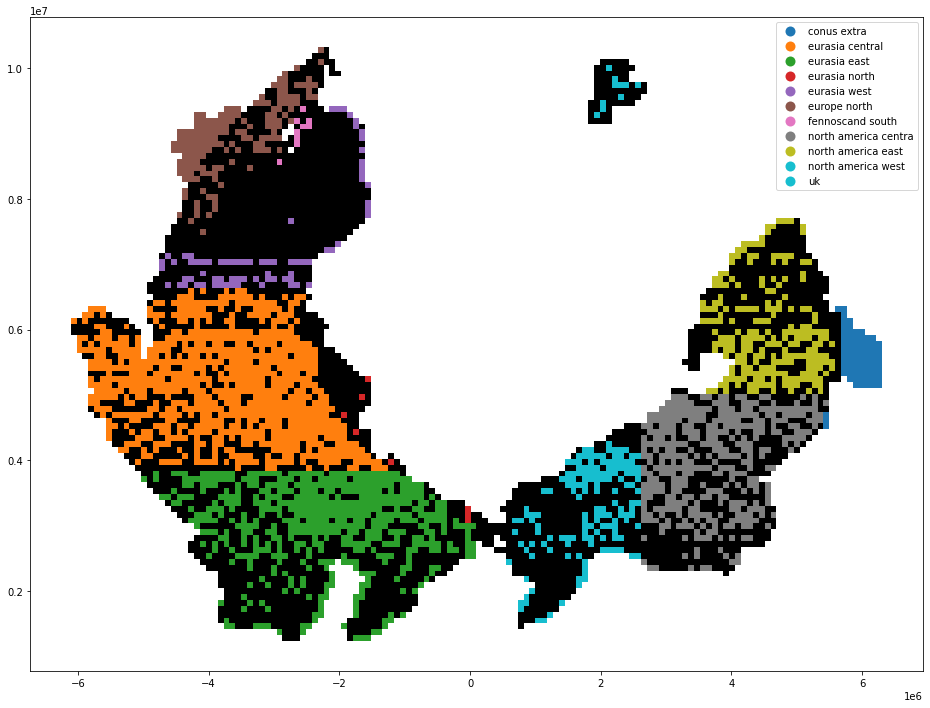

In [16]:
AGB_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = DPS_DATA_TYPE, \
                                                tindex_master_fn = AGB_tindex_master_fn,\
                                                boreal_tile_index_path = boreal_tile_index_path)

In [17]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

# For the tindex_master, convert it into vector tiles that show the tiles we have
cols_list = ['tile_num','s3_path','local_path']

# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(BAD_TILE_LIST)][cols_list], how='right', on='tile_num')
tile_index_matches = tile_index_matches[tile_index_matches['s3_path'].notna()]
tile_index_matches.head()

,tile_num,tile_version,tile_group,map_version,geometry,s3_path,local_path
0,26289,version 2,europe north,None,"POLYGON ((-3411478.000 9243304.000, -3321478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...
1,3119,version 1,north america centra,None,"POLYGON ((4328521.915 3483304.357, 4418522.303...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...
2,997,version 1,eurasia central,None,"POLYGON ((-5841478.000 6183304.000, -5751478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...
3,29480,version 2,europe north,None,"POLYGON ((-4311478.000 8163304.000, -4221478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...
4,573,version 1,north america east,None,"POLYGON ((4328522.000 7083304.000, 4418522.000...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...


## Build a MosaicJSON

##### Build tile geojsons needed for mosaic jsons

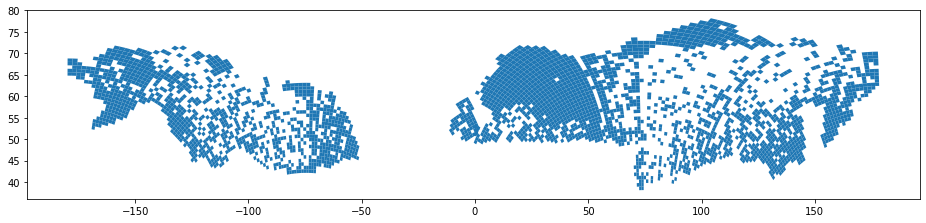

In [18]:
# Corrections were made to ensure GeoJSON *_tindex_master.json was set correctly to 4326
tile_matches_geojson_string = tile_index_matches.to_crs("EPSG:4326")

#Write copy to disk for debug 
tile_matches_geojson_string.to_file(tile_matches_geojson_fn, driver='GeoJSON')

tile_matches_geojson_string.plot()
tile_matches_geojson_string = tile_matches_geojson_string.to_json()

# This is formatted nicely (printed)
tile_matches_geojson = json.loads(tile_matches_geojson_string)

In [19]:

from typing import Dict
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3_path"]

#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 
#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/alexdevseed/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 

print(f"Building {out_mosaic_json_fn}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json_fn, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building /projects/my-public-bucket/DPS_tile_lists/spring2022/HLS_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


In [20]:
z = geopandas.read_file(tile_matches_geojson_fn)
tile_matches_geojson_fn
z.head().s3_path.to_list()

['s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/spring2022/04/02/02/36/55/007789/HLS_26289_06-15_09-01_2019_2021.tif',
 's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/spring2022/04/02/02/36/34/669962/HLS_3119_06-15_09-01_2019_2021.tif',
 's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/spring2022/04/02/02/35/37/005154/HLS_997_06-15_09-01_2019_2021.tif',
 's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/spring2022/04/02/02/34/01/153546/HLS_29480_06-15_09-01_2019_2021.tif',
 's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/spring2022/04/02/02/32/58/145751/HLS_573_06-15_09-01_2019_2021.tif']